Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


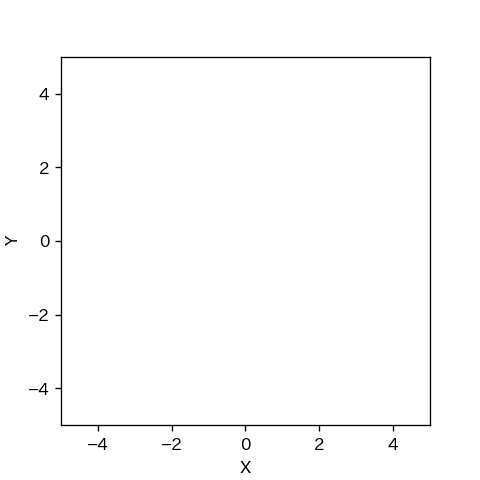

In [1]:
import sys
sys.path.append("../scripts/")
from mcl import *

In [2]:
class ResetMcl(Mcl):
    def __init__(self,envmap,init_pose,num,motion_noise_stds={"nn":0.19,"no":0.001,"on":0.13,"oo":0.2},
                distance_dev_rate=0.14,direction_dev=0.05,alpha_threshold=0.001,expansion_rate=0.2):
        super().__init__(envmap,init_pose,num,motion_noise_stds,distance_dev_rate,direction_dev)
        self.alpha_threshold=alpha_threshold
        self.expansion_rate=expansion_rate
        self.counter=0
        
    def random_reset(self):
         for p in self.particles:
                p.pose=np.array([np.random.uniform(-5.0,5,0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
                p.weight=1/len(self.particles)
    
    def sensor_resetting_draw(self,particle,landmark_pos,ell_obs,phi_obs):
             ##パーティクルの位置を決める##
                psi=np.random.uniform(-np.pi,np.pi) #ランドマークからの方角を選ぶ
                ell=norm(loc=ell_obs,scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
                particle.pose[0]=landmark_pos[0]+ell*math.cos(psi)
                particle.pose[1]=landmark_pos[1]+ell*math.sin(psi)
                
            ##パーティクルの向きを決める##
                phi=norm(loc=phi_obs,scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
                particle.pose[2]=math.atan2(landmark_pos[1]-particle.pose[1],landmark_pos[0]-particle.pose[0])-phi
            
                particle.weight=1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self,observation):
        nearest_obs=np.argmin([obs[0][0] for obs in observation]) #距離が一番近いランドマークを選択
        values, landmark_id=observation[nearest_obs]
        
        for p in self.particles:
            self.sensor_resetting_draw(p,self.map.landmarks[landmark_id].pos,*values)
            
        print(list([obs[0][0] for obs in observation]))
            
    def expansion_resetting(self):
        for p in self.particles:
            p.pose+=multivariate_normal(cov=np.eye(3)*(self.expansion_rate**2)).rvs()
            p.weight=1.0/len(self.particles)
            
    def observation_update(self,observation):
        for p in self.particles:
            p.observation_update(observation,self.map,self.distance_dev_rate,self.direction_dev)
     
        self.set_ml()
        
        if sum([p.weight for p in self.particles]) < self.alpha_threshold:
            self.counter += 1
            if self.counter < 5:
                self.expansion_resetting() #expansion_resettingに変更
            else:
                self.sensor_resetting(observation)
        else:
            self.counter=0
            self.resampling()

In [3]:
def trial_kidnap(animation): ###mclkidnap1test
    time_interval=0.1
    world=World(30,time_interval,debug=not animation)
    
    ##地図を生成して3つランドマークを追加##
    m=Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)
    
    ##ロボットを作る##
    init_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    robot_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    pf=ResetMcl(m,init_pose,100)
    a=EstimationAgent(time_interval,0.2,10.0/180*math.pi,pf)
    r=Robot(robot_pose,sensor=Camera(m),agent=a,color="red")
    world.append(r)
    
    world.draw()
    
    return(r.pose, pf.ml.pose)

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


<IPython.core.display.Javascript object>


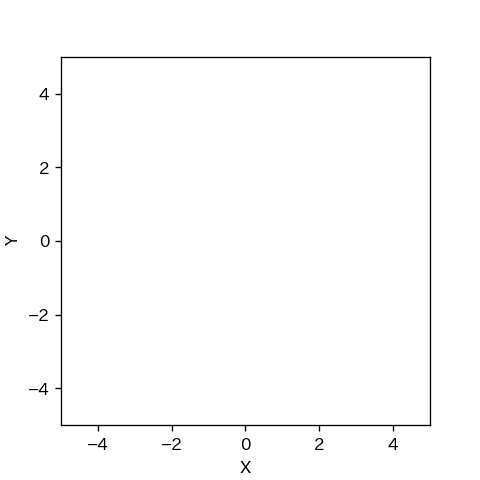

(array([3.92433707, 3.64608386, 0.4930034 ]),
 array([1.87899319, 2.34812865, 2.03670097]))

In [4]:
trial_kidnap(True)

In [5]:
if __name__=='__main__': ###mclglobal1exec
    ok=0
    for i in range(1000):
        actual, estm=trial_kidnap(False)
        diff = math.sqrt((actual[0]-estm[0])**2 + (actual[1]-estm[1])**2)
        print(i, "真値:",actual, "推定値:", estm, "誤差:", diff)
        if diff<=1.0:
            ok += 1
            print(ok)

[5.055925440680618]
[6.527973272033045]
0 真値: [-2.50314019 -4.3206794   7.17645283] 推定値: [-2.33214664 -3.93639461  0.85164564] 誤差: 0.42061097094070377
1
[3.928558305091763]
[2.11173554315042]
1 真値: [ 3.67432888 -1.08006477  8.42525499] 推定値: [ 3.03328704 -0.98850875  2.01414707] 誤差: 0.6475470181397818
2
[4.749272482195939]
2 真値: [-2.47190753  3.64490299  3.70833548] 推定値: [-3.08078064  4.986324    4.19438217] 誤差: 1.473138413948934
[4.87320831898799]
3 真値: [ 2.68235819 -1.38936103  4.67334207] 推定値: [ 2.2542765  -1.55986379  4.87122133] 誤差: 0.4607875091338054
3
4 真値: [-6.31874952  3.16545602  4.60480821] 推定値: [3.94774313 0.59004718 1.29127942] 誤差: 10.584592675733015
5 真値: [ 2.05782979 -3.47869839  2.75891569] 推定値: [ 1.73687811 -2.60643206  6.40528806] 誤差: 0.9294399000956304
4
[3.7715942379986007]
[5.961871937648156]
6 真値: [-0.43734812  1.46294609  7.33680214] 推定値: [-0.74924287  1.57549022  0.94126839] 誤差: 0.3315788279783183
5
[6.502268960577367]
[4.938899835332474, 4.956995579963888]
[7.55

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


[4.162939635652143]
[3.8614467870383864, 3.525992886792293]
[3.395449236757479]
20 真値: [ 4.54426794 -1.17918855  3.99274426] 推定値: [ 4.40335652 -1.74571609 -2.47993797] 誤差: 0.5837889010265089
12
[4.9576280156968355]
21 真値: [-0.95248829 -6.42471414  1.61545093] 推定値: [ 5.76733858 -3.10907535 -2.4633458 ] 誤差: 7.493299254779567
[1.4668346000434602]
22 真値: [4.03212997 1.36264419 6.69104674] 推定値: [3.65534786 1.90110025 0.0988771 ] 誤差: 0.6571907536478413
13
[2.72662154136668]
23 真値: [-1.30520136  3.50445555  5.97614598] 推定値: [-1.04590635  2.96673409  6.10840834] 誤差: 0.5969742588480794
14
[5.218398854715628]
24 真値: [-3.75973778 -1.09493055  2.76196047] 推定値: [-3.52779156 -0.753043    2.81662896] 誤差: 0.4131418033484912
15
[4.060656311007879]
[5.1422303207557585]
25 真値: [-1.44444821 -4.08205118  6.73292747] 推定値: [-0.83160984 -4.42266525  0.6336806 ] 誤差: 0.701133946932304
16
[2.8804114568929395]
26 真値: [4.51900047 1.99490866 2.95115166] 推定値: [1.63858984 2.43024833 0.85275883] 誤差: 2.9131230717639376